# Experiments DPT & BCEDiceLoss

## Vision Transformers for Dense Prediction

Code: https://github.com/isl-org/DPT

In [19]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
import time
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
import seaborn as sns

from torch.utils.data import random_split, DataLoader

from hubmap.models.dpt import DPT
from hubmap.dataset import BaseDataset
from hubmap.data import DATA_DIR
from hubmap.losses.bce_dice_loss import BCEDiceLoss

In [27]:
transformations = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
#     transforms.RandomHorizontalFlip()
])

In [28]:
dataset = BaseDataset(DATA_DIR, transform=transformations)

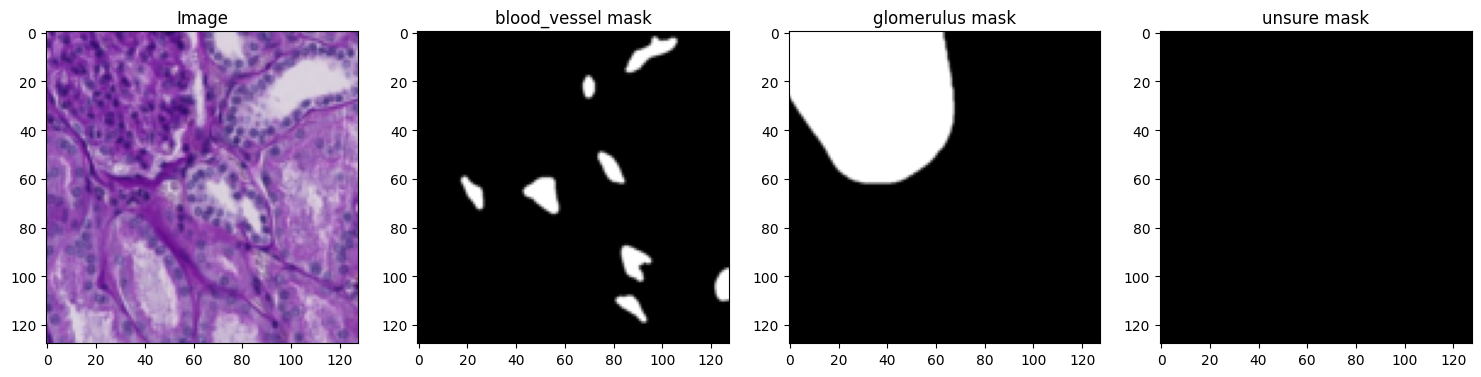

In [29]:
dataset.plot_example(0)

In [15]:
TRAIN_SPLIT = 0.8
train_size = int(TRAIN_SPLIT * len(dataset))
val_size = len(dataset) - train_size

In [16]:
td, vd = random_split(dataset, [train_size, val_size])

In [17]:
BATCH_SIZE = 4

In [18]:
tl = DataLoader(td, batch_size=BATCH_SIZE, shuffle=True)
vl = DataLoader(vd, batch_size=BATCH_SIZE, shuffle=False)

In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using Device: {device}")

Using Device: cuda


In [45]:
model = DPT(num_classes=1, features=128)
model = model.to(device)

In [46]:
criterion = BCEDiceLoss()

In [47]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)

In [48]:
train_losses = train_accs = []
val_losses = val_accs = []

In [283]:
n_epochs = 1

In [ ]:
for epoch in range(n_epochs):
    epoch_start_time = time.time()
    train_start_time = time.time()
    train_batch_losses = train_batch_accs = []
    model.train()
    for images, targets in tl:
        images = images.to(device)
        
        # Only select the blood vessels target mask.
        targets = targets[:, 0:1, ...]
        targets = targets.to(device)

        optimizer.zero_grad()
        preds = model(images)

        loss = criterion(preds, targets)
        loss.backward()
        optimizer.step()
        
#         acc = calculate_segmentation_accuracy(
#             preds.detach(), targets.detach(), device
#         )

        train_batch_losses.append(loss.item())
#         train_batch_accs.append(acc.item())
    train_end_time = time.time()
    
    val_start_time = time.time()
    val_batch_losses = val_batch_accs = []
    model.eval()
    for images, targets in vl:
        images = images.to(device)
        
        # Only select the blood vessels target mask.
        targets = targets[:, 0:1, ...]
        targets = targets.to(device)
                
        with torch.no_grad():
            preds = model(images)
            loss = criterion(preds, targets)
            
#             acc = calculate_segmentation_accuracy(
#                 preds.detach(), targets.detach(), device
#             )
        
        val_batch_losses.append(loss.item())
#         val_batch_accs.append(acc.item())
    val_end_time = time.time()
    
    train_losses.append(np.mean(train_batch_losses))
#     train_accs.append(np.mean(train_batch_accs))
    val_losses.append(np.mean(val_batch_losses))
#     val_accs.append(np.mean(val_batch_accs))
    
    epoch_end_time = time.time()
    
    train_timing = train_end_time - train_start_time
    train_timing = time.strftime("%H:%M:%S", time.gmtime(train_timing))

    val_timing = val_end_time - val_start_time
    val_timing = time.strftime("%H:%M:%S", time.gmtime(val_timing))
    
    epoch_timing = epoch_end_time - epoch_start_time
    epoch_timing = time.strftime("%H:%M:%S", time.gmtime(epoch_timing))

    print(
        f"Epoch ({epoch_timing}) {epoch+1}/{n_epochs} | "
        f"Train ({train_timing}): Loss = {np.mean(train_batch_losses):.6f} | "
#         f"- Accuracy = {(np.mean(train_batch_accs) * 100):.2f}% | "
        f"Val ({val_timing}): Loss = {np.mean(val_batch_losses):.6f}"  # | "
#         f"- Accuracy = {(np.mean(val_batch_accs) * 100):.2f}%"
    )

Text(0.5, 0.98, 'Training And Validation Loss of DPT')

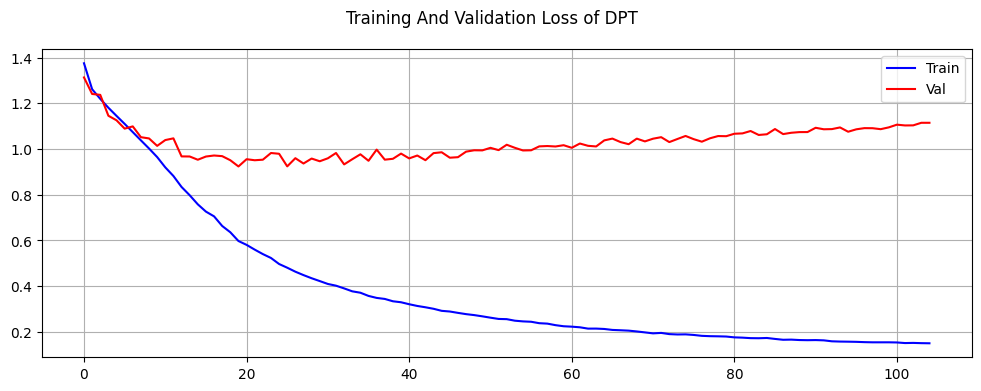

In [113]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(12, 4))

axs.grid()
sns.lineplot(train_losses, color="blue", label="Train")
sns.lineplot(val_losses, color="red", label="Val")
fig.suptitle("Training And Validation Loss of DPT")

In [30]:
def visualize_results(f: int, t: int, data):
    samples = []
    for i in range(f, t):
        wsi, target = data[i]
        
        model.eval()
        with torch.no_grad():
            pred = model(wsi.unsqueeze(0).to(device))
            logits = pred.detach().cpu()
            mask = F.sigmoid(logits)
        
        samples.append((
                wsi.squeeze(0).permute(1, 2, 0),
                target.permute(1, 2, 0),
                mask.squeeze(0).permute(1, 2, 0)
        ))
        
    fig_height = 2.5 * len(samples)
    fig, axs = plt.subplots(nrows=len(samples), ncols=2, figsize=(5,  fig_height))
    for i, (wsi, target, mask) in enumerate(samples):
        if i == 0:
            axs[i][0].set_title("Ground Truth")
            axs[i][1].set_title("Prediction")

        axs[i][0].imshow(wsi)
        axs[i][0].imshow(target, alpha=0.3)

        axs[i][1].imshow(wsi)
        axs[i][1].imshow(mask, alpha=0.5)

    plt.tight_layout()
#     plt.suptitle("Overlay of Ground Truth and Prediction (Sample from Training Data)")
    plt.show()

In [31]:
visualize_results(f=20, t=23, data=td)

NameError: name 'model' is not defined

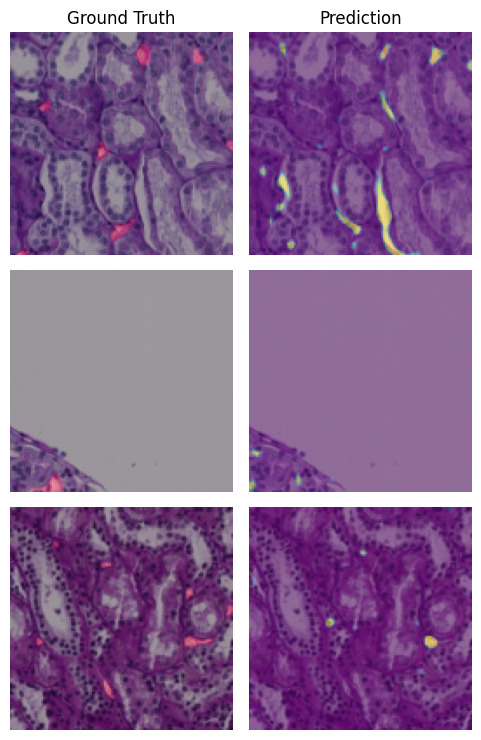

In [229]:
visualize_results(f=20, t=23, data=vd)